In [1]:
# %%
##############################################################
############### Examining average performance across experimental connditionns. MD ablation, vmPFC ablation and with and without OFC
##############################################################
import matplotlib as mpl
import matplotlib
mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, re, sys
import pickle
import glob
import itertools
from tqdm import tqdm
sys.path.append('./../')
file_format= 'JPG'



In [2]:
exp_name = 'dynamic_eligibility_trace/HebbianLearning'
results_folder = './../results/'
config_files = glob.glob(results_folder  + exp_name + "/" + "config*")
log_files = glob.glob(results_folder  + exp_name + "/" + "log*")

var1s   = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
var1s   = [ 10, 50, 100, 200, 300,  400, 500, 600]

var2s   = [0.02, 0.08, .10, .12,.2, ]
task_vars = list(itertools.product(var1s, var2s)) #810 length

# for var1, var2 in task_vars:

            

variable_values = var1s

no_of_values = len(variable_values)
norm = mpl.colors.Normalize(vmin=min([1,no_of_values]), vmax=max([1,no_of_values]))
cmap_obj = matplotlib.cm.get_cmap('viridis')
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)


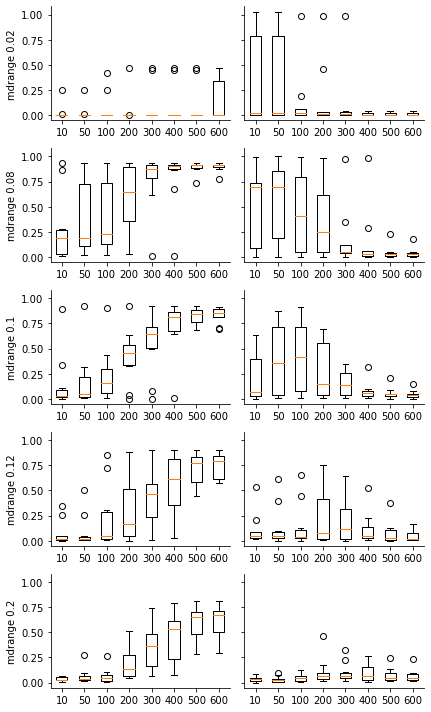

In [3]:

def get_md_modulations(var2_to_run):
    vars = [(var1, var2) for var1 in var1s for var2 in [var2_to_run]]
    # regexes = [f"\d_{float(var1):1.0f}_{float(var2):1.0f}_1.0" if var2%1==0 else f"\d_{float(var1):1.0f}_{float(var2):1.1f}_1.0" for var1, var2 in vars ]  
    regexes = [f"\d_{float(var1):1.0f}_{float(var2):1.1f}_4.0" if var2%0.1==0 else f"\d_{float(var1):1.0f}_{float(var2):1.2f}_4.0" for var1, var2 in vars ]  
    labels = [f"{var1} {var2}" for var1, var2  in vars]

    means, stds, md_cmodulations, md_smodulations = [], [], [], []
    means_all = [] # means pooled the other axis, pooling all trials for each run.
    for i, (label, regex) in enumerate(zip(labels, regexes)):
        comp_files =  [file for file in log_files if re.search(regex, file)]
        conf_files =   [file for file in config_files if re.search(regex, file)]
        if len(comp_files) > 0:
            # print('++++++++++++++++++++++++++++++\n',comp_files)
            performances, cmods, smods =[], [], []
            for log_file, config_file in zip (comp_files, conf_files):
                log = np.load(log_file, allow_pickle=True).item()
                config = np.load(config_file, allow_pickle=True).item()
                # if log.md_context_modulation > 0.8 : 
                performances.append(log.corrects)
                cmods.append(log.md_context_modulation)

                cue_vector = np.ones(np.sum(config.variable_trials_per_block))
                cue_vector[log.Inputs[:,1] == 1] = -1
                log.md_cue_modulation = np.abs( np.dot(cue_vector, log.MDrates.mean(1)[:,0]/np.sum(cue_vector>0)))

                smods.append(log.md_cue_modulation)
            # smooth_performances = [np.convolve(performance, np.ones((40,))/40, mode='valid') for performance in performances]
            # sp = np.stack(smooth_performances)
            # spmean = np.mean(sp, axis=0)    
            # spstd = np.std(sp, axis=0)    
            # means.append(spmean)
            # means_all.append(sp.mean(1))
            # stds.append(spstd)
            md_cmodulations.append(cmods)
            md_smodulations.append(smods)
        else:
            print(f'no files found for {label}  regex {regex}')
    return (md_cmodulations, md_smodulations, labels)


fig, axes = plt.subplots(len(var2s),2 , figsize=[6, len(var2s)*2], sharey=True)
for i in range(len(var2s)):
    md_cmodulations, md_smodulations, labels = get_md_modulations(var2s[i])
    ax = axes[i,0]
    _=ax.boxplot(md_cmodulations)
    _=ax.set_xticklabels(var1s)
    ax.set_ylabel(f'mdrange {var2s[i]}')
    ax = axes[i,1]
    _=ax.boxplot(md_smodulations)
    _=ax.set_xticklabels(var1s)
fig.tight_layout()

In [22]:
detailed_log = np.load('./../results/dynamic_eligibility_trace/HebbianLearning/log_0_2000_0.1_4__01-09_23:30.npy' , allow_pickle=True).item()

In [18]:
srt = np.argsort(detailed_log.MDpreTraces[:500, :].mean(0))

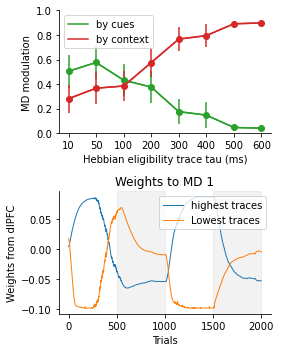

In [29]:
fig, axes = plt.subplots(2,1 , figsize=[4, 5], sharey=False)
md_cmodulations, md_smodulations, labels = get_md_modulations(0.08)
ax = axes[0]
_mods = md_smodulations
ax.plot([np.mean(m) for m in _mods], color = 'tab:green', label='by cues')
ax.plot([np.mean(m) for m in _mods], 'o', color = 'tab:green')
ax.set_ylim([0,1])
ax.errorbar(range(8), [np.mean(m) for m in _mods], [np.std(m)/np.sqrt(len(_mods)) for m in _mods], color = 'tab:green')

_mods = md_cmodulations
ax.plot([np.mean(m) for m in _mods], color = 'tab:red', label='by context')
ax.plot([np.mean(m) for m in _mods], 'o', color = 'tab:red')
ax.set_ylim([0,1])
ax.errorbar(range(8), [np.mean(m) for m in _mods], [np.std(m)/np.sqrt(len(_mods)) for m in _mods], color = 'tab:red')
ax.legend()
ax.set_xticks(range(8))
_=ax.set_xticklabels(var1s)
ax.set_ylabel('MD modulation')
ax.set_xlabel('Hebbian eligibility trace tau (ms)')

ax = axes[1]
# _=ax.plot(detailed_log.wPFC2MDs[:, 0, srt[:5]] , linewidth=0.5 ) # (2000, 2, 500)
_=ax.plot(detailed_log.wPFC2MDs[:, 0, srt[:5]].mean(1), linewidth=1 , label='highest traces') # (2000, 2, 500)
_=ax.plot(detailed_log.wPFC2MDs[:, 0, srt[-5:]].mean(1), linewidth=1 , label='Lowest traces') # (2000, 2, 500)
ax.set_ylabel('Weights from dlPFC')
ax.set_title('Weights to MD 1')
ax.set_xlabel('Trials')
ax.legend()
tpb= 500
for ib in range(1, 4,2):
            ax.axvspan(tpb* ib, tpb*(ib+1), alpha=0.1, color='grey')
# ax = axes[1,1]
# # _=ax.plot(detailed_log.wPFC2MDs[:, 1, srt[:5]] ) # (2000, 2, 500)
# _=ax.plot(detailed_log.wPFC2MDs[:, 1, srt[:5]].mean(1), linewidth=1 ) # (2000, 2, 500)
# _=ax.plot(detailed_log.wPFC2MDs[:, 1, srt[-5:]].mean(1), linewidth=1 ) # (2000, 2, 500)
# # ax.set_ylabel('Weights from dlPFC')
# ax.set_title('Weights to MD 2')
# ax.set_xlabel('Trials')
# for ib in range(1, 4,2):
#             ax.axvspan(tpb* ib, tpb*(ib+1), alpha=0.1, color='grey')

# for i in range(2):
#     axes[i,0].get_shared_y_axes().join(axes[i,0], axes[i,1])

fig.tight_layout()
# plt.savefig('./exports/Figure_Hebbian.PDF', dpi=300)